In [1]:
from ase.io.vasp import read_vasp_xdatcar, read_vasp

import sys
sys.path.append('tools/')

from displace import *

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
xdatcar = read_vasp_xdatcar('XDATCAR', index=0)

disps = []
for i in range(len(xdatcar)):
    disp = xdatcar[i].positions - xdatcar[0].positions
    disps.append(disp)

codeobj = get_code_object('VASP')

file_evec = 'kno_221.mesh.evec'
displacement_mode = 'pes'
file_primitive = 'PPOSCAR'
file_supercell = 'SPOSCAR'
codeobj.load_initial_structure(file_supercell)
codeobj_base = codeobj

supercell = read_vasp(file_supercell)

In [3]:
displace = AlamodeDisplace(
    displacement_mode=displacement_mode,
    codeobj_base=codeobj,
    file_evec=file_evec,
    file_primitive=file_primitive,
    verbosity=1,
)

In [4]:
eigenvectors = displace._evec[displace._qlist_real]

commensurate_q_points = displace._qpoints[displace._qlist_real]
q_points = commensurate_q_points

lattice_points = displace._mapping_shift

na = len(displace._mapping_s2p)
nq, ns = eigenvectors.shape[:2]

evs = eigenvectors.reshape(nq, ns, ns // 3, 3)
qR = (q_points @ lattice_points.T).repeat(3, axis=1).reshape(nq, na, -1)
phases = np.exp(2j * np.pi * qR)

masses = supercell.get_masses()
M = masses.reshape(-1,1).repeat(3,axis=1) ** 0.5

indeces = []
for i, a in enumerate(displace._mapping_s2p):
    indeces.append([a, i - a * displace._supercell.nat // displace._nat_primitive])
indeces = np.array(indeces)

In [5]:
# proj[a,b] ; a: qpoints, b: imode ; 
# You need to find the corresponding index for the q-point yourself.
# In this example, Gamma-point: a=0 ; M-point: a=6 ; R-point: a=7 
projs = []

for disp in tqdm(disps):
    projectors = np.zeros((nq, ns, na, 3))
    proj = np.zeros((nq, ns))
    for x in range(nq):
        for y in range(ns):
            projector = (evs[x,y][indeces[:,0],:] * phases[x][:,:]).real
            projectors[x,y] = projector

            proj[x,y] = np.sum(np.diag((M * disp) @ projector.T))    
    projs.append(proj)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.59it/s]


In [6]:
g = []
m = []
r = []

for p in projs:
    g.append(p[0,0])
    m.append(p[6,1])    
    r.append(p[7,0])

g_d = pd.DataFrame(data=g)
m_d = pd.DataFrame(data=m)
r_d = pd.DataFrame(data=r)

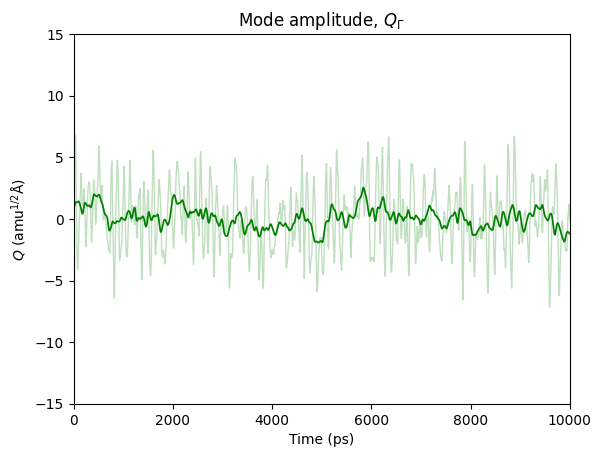

In [7]:
plt.title('Mode amplitude, $Q_\Gamma$')
plt.plot(range(10000), g_d, lw=1, alpha=0.25, color='green')
plt.plot(range(10000), g_d.rolling(min_periods=0, window=250,center=True).mean(), lw=1.25, color='green')
plt.xlabel('Time (ps)')
plt.ylabel('$Q$ (amu$^{1/2}$Å)')
plt.xlim(0,10000)
plt.ylim(-15,15)
plt.show()

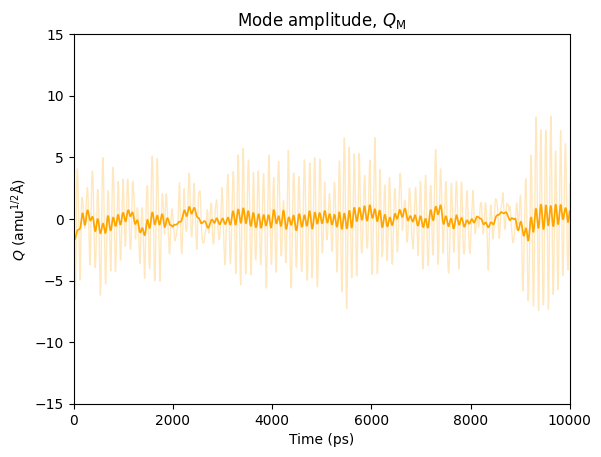

In [8]:
plt.title('Mode amplitude, $Q_{\mathrm{M}}$')
plt.plot(range(10000), m_d, lw=1, alpha=0.25, color='orange')
plt.plot(range(10000), m_d.rolling(min_periods=0, window=250,center=True).mean(), lw=1.25, color='orange')
plt.xlabel('Time (ps)')
plt.ylabel('$Q$ (amu$^{1/2}$Å)')
plt.xlim(0,10000)
plt.ylim(-15,15)
plt.show()

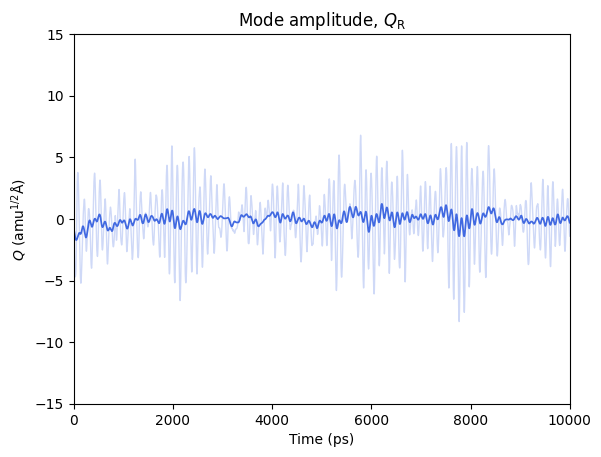

In [9]:
plt.title('Mode amplitude, $Q_{\mathrm{R}}$')
plt.plot(range(10000), r_d, lw=1, alpha=0.25, color='royalblue')
plt.plot(range(10000), r_d.rolling(min_periods=0, window=250,center=True).mean(), lw=1.25, color='royalblue')
plt.xlabel('Time (ps)')
plt.ylabel('$Q$ (amu$^{1/2}$Å)')
plt.xlim(0,10000)
plt.ylim(-15,15)
plt.show()